In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from keras import regularizers
from sklearn.model_selection import train_test_split
from CKD_utils import *
from CKD_models import *
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


Importing Data

In [2]:
T_creatinine = pd.read_csv('T_creatinine.csv')
T_DBP = pd.read_csv('T_DBP.csv')
T_demo = pd.read_csv('T_demo.csv')
T_glucose = pd.read_csv('T_glucose.csv')
T_HGB = pd.read_csv('T_HGB.csv')
T_ldl = pd.read_csv('T_ldl.csv')
T_meds = pd.read_csv('T_meds.csv')
T_SBP = pd.read_csv('T_SBP.csv')
T_stage = pd.read_csv('T_stage.csv')

Size of given EHR collection

In [3]:
print('T_creatinine: {} \nT_DBP: {} \nT_demo: {} \nT_glucose: {} \nT_HGB: {} \nT_ldl: {} \nT_meds: {} \nT_SBP: {} \nT_stage: {}'.format(T_creatinine.shape,
                                                                                                                                        T_DBP.shape,
                                                                                                                                        T_demo.shape,
                                                                                                                                        T_glucose.shape,
                                                                                                                                        T_HGB.shape,
                                                                                                                                        T_ldl.shape,
                                                                                                                                        T_meds.shape,
                                                                                                                                        T_SBP.shape,
                                                                                                                                        T_stage.shape))

T_creatinine: (1439, 3) 
T_DBP: (1821, 3) 
T_demo: (300, 4) 
T_glucose: (1556, 3) 
T_HGB: (2025, 3) 
T_ldl: (1261, 3) 
T_meds: (2181, 5) 
T_SBP: (1809, 3) 
T_stage: (300, 2)


Unique Values

In [4]:
print('T_creatinine: {} \nT_DBP: {} \nT_demo: {} \nT_glucose: {} \nT_HGB: {} \nT_ldl: {} \nT_meds: {} \nT_SBP: {} \nT_stage: {}'.format(T_creatinine['id'].unique().shape,
                                                                                                                                        T_DBP['id'].unique().shape,
                                                                                                                                        T_demo['id'].unique().shape,
                                                                                                                                        T_glucose['id'].unique().shape,
                                                                                                                                        T_HGB['id'].unique().shape,
                                                                                                                                        T_ldl['id'].unique().shape,
                                                                                                                                        T_meds['id'].unique().shape,
                                                                                                                                        T_SBP['id'].unique().shape,
                                                                                                                                        T_stage['id'].unique().shape))

T_creatinine: (300,) 
T_DBP: (300,) 
T_demo: (300,) 
T_glucose: (300,) 
T_HGB: (300,) 
T_ldl: (300,) 
T_meds: (272,) 
T_SBP: (300,) 
T_stage: (300,)


Number of days for which data is given

In [5]:
print('T_creatinine: {} \nT_DBP: {}  \nT_glucose: {} \nT_HGB: {} \nT_ldl: {} \nT_meds: {} \nT_SBP: {}'.format(max(T_creatinine['time']),
                                                                                                              max(T_DBP['time']),
                                                                                                              max(T_glucose['time']),
                                                                                                              max(T_HGB['time']),
                                                                                                              max(T_ldl['time']),
                                                                                                              max(T_meds['end_day']),
                                                                                                              max(T_SBP['time'])))

T_creatinine: 699 
T_DBP: 699  
T_glucose: 699 
T_HGB: 1429 
T_ldl: 699 
T_meds: 698 
T_SBP: 699


Fields

In [6]:
print('T_creatinine: {} \nT_DBP: {} \nT_demo: {} \nT_glucose: {} \nT_HGB: {} \nT_ldl: {} \nT_meds: {} \nT_SBP: {} \nT_stage: {}'.format(T_creatinine.columns.values,
                                                                                                                                        T_DBP.columns.values,
                                                                                                                                        T_demo.columns.values,
                                                                                                                                        T_glucose.columns.values,
                                                                                                                                        T_HGB.columns.values,
                                                                                                                                        T_ldl.columns.values,
                                                                                                                                        T_meds.columns.values,
                                                                                                                                        T_SBP.columns.values,
                                                                                                                                        T_stage.columns.values))

T_creatinine: ['id' 'value' 'time'] 
T_DBP: ['id' 'value' 'time'] 
T_demo: ['id' 'race' 'gender' 'age'] 
T_glucose: ['id' 'value' 'time'] 
T_HGB: ['id' 'value' 'time'] 
T_ldl: ['id' 'value' 'time'] 
T_meds: ['id' 'drug' 'daily_dosage' 'start_day' 'end_day'] 
T_SBP: ['id' 'value' 'time'] 
T_stage: ['id' 'Stage_Progress']


Race and gender

In [7]:
print(T_demo['race'].unique())
print(T_demo['gender'].unique())

['Unknown' 'White' 'Black' 'Asian' 'Hispanic']
['Male' 'Female']


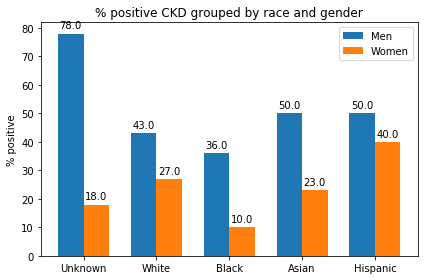

In [8]:
combined_table = pd.merge(T_stage, T_demo, how='inner', on='id')
labels = ['Unknown', 'White', 'Black', 'Asian', 'Hispanic']
men_means = []
women_means = []
for x in labels:
    for gen in ['Male', 'Female']:
        combined = combined_table[combined_table['race']==x]
        combined_number = combined[combined['gender']==gen]['Stage_Progress'].count()
        combined2 = combined[combined['gender']==gen]['Stage_Progress']
        combined_true = combined2[combined2==True].count()
        if gen == "Male":
            men_means.append(round(combined_true/combined_number*100))
        elif gen == 'Female':
            women_means.append(round(combined_true/combined_number*100))

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Men')
rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% positive')
ax.set_title('% positive CKD grouped by race and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

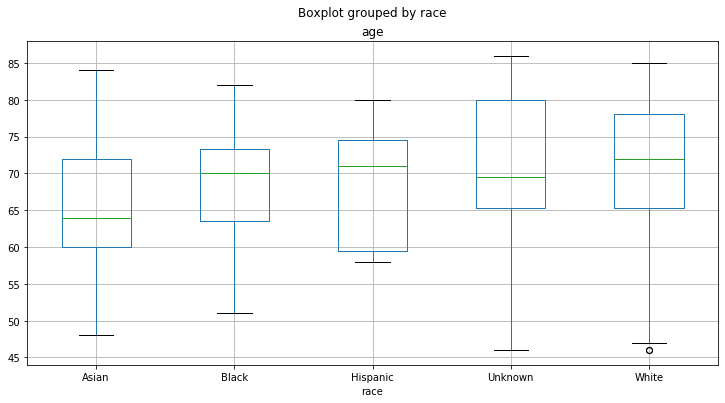

In [9]:
combined_table.boxplot(column='age', by='race', figsize=(12,6))

Medicine

In [10]:
T_meds['drug'].unique().tolist()

['atorvastatin',
 'losartan',
 'metformin',
 'rosuvastatin',
 'pravastatin',
 'carvedilol',
 'valsartan',
 'metoprolol',
 'simvastatin',
 'bisoprolol',
 'atenolol',
 'lovastatin',
 'olmesartan',
 'irbesartan',
 'canagliflozin',
 'dapagliflozin',
 'telmisartan',
 'labetalol',
 'nebivolol',
 'pitavastatin',
 'propranolol']

Train, validation and test split

In [11]:
train_demo, validation_demo = train_test_split(T_demo, test_size = 0.4, random_state=100)
validation_demo, test_demo = train_test_split(validation_demo, test_size = 0.5, random_state=100)
print(train_demo.shape, validation_demo.shape, test_demo.shape)

(180, 4) (60, 4) (60, 4)


Data augmentation

In [12]:
train_list = data_augment(T_creatinine, T_DBP, T_SBP, T_glucose, T_ldl, T_HGB, train_demo, T_meds, T_stage, 300)
length1 = train_list[6]['id'].max() + 120
validation_list = data_augment(T_creatinine, T_DBP, T_SBP, T_glucose, T_ldl, T_HGB, validation_demo, T_meds, T_stage, length1)
length2 = validation_list[6]['id'].max() + 60
test_list = data_augment(T_creatinine, T_DBP, T_SBP, T_glucose, T_ldl, T_HGB, test_demo, T_meds, T_stage, length2)

C:\Users\shala\OneDrive\Documents\Python Scripts\dataScienceTask\CKD_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  add_row['id']= counter+length


Getting input array

In [13]:
train_sentences, train_aux_sentences = get_final_array(train_list)
validation_sentences, validation_aux_sentences = get_final_array(validation_list)
test_sentences, test_aux_sentences = get_final_array(test_list)
train_labels = np.asarray(train_list[8]['Stage_Progress']*1)
validation_labels = np.asarray(validation_list[8]['Stage_Progress']*1)
test_labels = np.asarray(test_list[8]['Stage_Progress']*1)

Model 1

In [14]:
model_0 = GRU_model()
model_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               60288     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [15]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.001)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model_0', monitor='loss', restore_best_weights=True)
callbacks = [reduce_lr, model_checkpoint]

history_0=model_0.fit(x=([train_sentences]), y=[train_labels],  epochs=30, validation_data=([validation_sentences], validation_labels), verbose=2, callbacks=callbacks)

Train on 1123 samples, validate on 389 samples
Epoch 1/30
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_0\assets
1123/1123 - 33s - loss: 0.7841 - accuracy: 0.6572 - f1_factor: 0.0617 - val_loss: 0.6855 - val_accuracy: 0.6710 - val_f1_factor: 0.0879
Epoch 2/30
INFO:tensorflow:Assets written to: model_0\assets
1123/1123 - 29s - loss: 0.6955 - accuracy: 0.6830 - f1_factor: 0.2718 - val_loss: 0.6703 - val_accuracy: 0.8072 - val_f1_factor: 0.7126
Epoch 3/30
INFO:tensorflow:Assets written to: model_0\assets
1123/1123 - 29s - loss: 0.7079 - accuracy: 0.7213 - f1_factor: 0.4176 - val_loss: 0.5575 - val_accuracy: 0.7326 - val_f1_factor: 0.5262
Epoch 4/30
INFO:tensorflow:Assets written to: model_0\assets
1123/1123 - 29s - loss: 0.6129 - accuracy: 0.7222 - f1_factor: 0.5114 - val_loss: 2.0131 - val_accuracy: 0.6838 - val_f1_factor: 0.5414
Epoch 5/30
INFO:tensorflow:Assets written to: model_0\assets
1123/1123 - 29s - loss:

In [16]:
pred = np.around(model_0.predict([test_sentences]).astype(float))
confusion_matrix(test_labels, pred, labels=[1,0])

array([[ 47,  51],
       [ 80, 198]], dtype=int64)

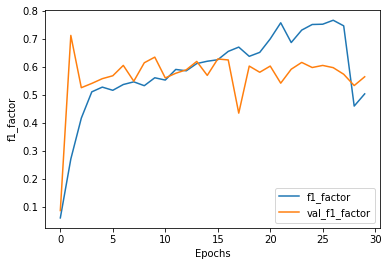

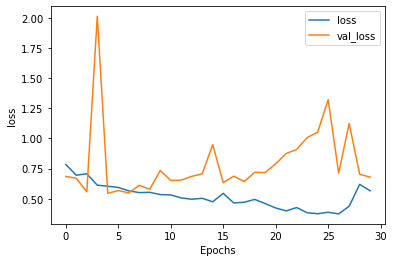

In [17]:
plot_graphs(history_0, "f1_factor")
plot_graphs(history_0, "loss")

Model 2

In [18]:
model_1 = CNN_GRU_model()
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 700, 27)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 696, 128)     17408       main_input[0][0]                 
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 232, 128)     0           conv1d[0][0]                     
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 232, 128)     0           max_pooling1d[0][0]              
______________________________________________________________________________________________

In [19]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.001)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model_0', monitor='loss', restore_best_weights=True)
callbacks = [reduce_lr, model_checkpoint]

history_1=model_1.fit(x=([train_sentences, train_aux_sentences]), y=[train_labels],  epochs=30, validation_data=([validation_sentences, validation_aux_sentences], validation_labels), verbose=2, callbacks=callbacks)

Train on 1123 samples, validate on 389 samples
Epoch 1/30
INFO:tensorflow:Assets written to: model_0\assets
1123/1123 - 20s - loss: 1.4682 - accuracy: 0.6358 - f1_factor: 0.1410 - val_loss: 1.3132 - val_accuracy: 0.7712 - val_f1_factor: 0.3854
Epoch 2/30
INFO:tensorflow:Assets written to: model_0\assets
1123/1123 - 12s - loss: 1.2152 - accuracy: 0.7106 - f1_factor: 0.4140 - val_loss: 1.0766 - val_accuracy: 0.7352 - val_f1_factor: 0.6412
Epoch 3/30
INFO:tensorflow:Assets written to: model_0\assets
1123/1123 - 11s - loss: 0.9955 - accuracy: 0.7738 - f1_factor: 0.6028 - val_loss: 1.1895 - val_accuracy: 0.6658 - val_f1_factor: 0.5948
Epoch 4/30
INFO:tensorflow:Assets written to: model_0\assets
1123/1123 - 12s - loss: 0.8051 - accuracy: 0.8246 - f1_factor: 0.6736 - val_loss: 1.1674 - val_accuracy: 0.7147 - val_f1_factor: 0.5676
Epoch 5/30
INFO:tensorflow:Assets written to: model_0\assets
1123/1123 - 12s - loss: 0.6837 - accuracy: 0.8433 - f1_factor: 0.7402 - val_loss: 3.0906 - val_accuracy:

In [20]:
pred = np.around(model_1.predict([test_sentences, test_aux_sentences]).astype(float))
confusion_matrix(test_labels, pred, labels=[1,0])

array([[ 73,  25],
       [109, 169]], dtype=int64)

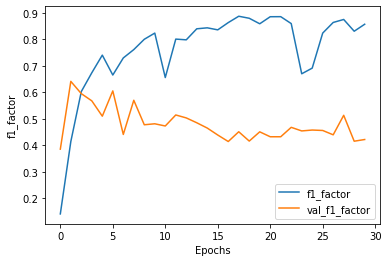

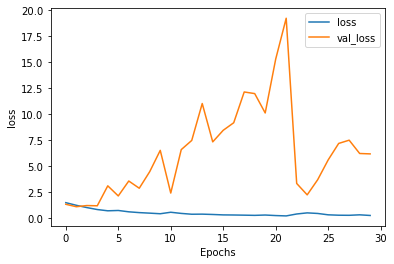

In [21]:
plot_graphs(history_1, "f1_factor")
plot_graphs(history_1, "loss")

In [14]:
model_2 = inceptionTime_model()
model_2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 700, 27)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 700, 32)      896         main_input[0][0]                 
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 700, 27)      0           main_input[0][0]                 
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 700, 32)      10272       conv1d[0][0]                     
______________________________________________________________________________________________

In [15]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.001)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model_0', monitor='loss', restore_best_weights=True)
callbacks = [reduce_lr, model_checkpoint]

history_2=model_2.fit(x=([train_sentences, train_aux_sentences]), y=[train_labels],  epochs=30, validation_data=([validation_sentences, validation_aux_sentences], validation_labels), verbose=2, callbacks=callbacks)

Train on 1123 samples, validate on 389 samples
Epoch 1/30
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_0\assets
1123/1123 - 13s - loss: 0.6324 - accuracy: 0.6447 - f1_factor: 0.4409 - val_loss: 0.6941 - val_accuracy: 0.5604 - val_f1_factor: 0.4403
Epoch 2/30
INFO:tensorflow:Assets written to: model_0\assets
1123/1123 - 8s - loss: 0.5254 - accuracy: 0.7382 - f1_factor: 0.5558 - val_loss: 0.6609 - val_accuracy: 0.6992 - val_f1_factor: 0.3323
Epoch 3/30
INFO:tensorflow:Assets written to: model_0\assets
1123/1123 - 8s - loss: 0.4309 - accuracy: 0.7996 - f1_factor: 0.6452 - val_loss: 0.6697 - val_accuracy: 0.6581 - val_f1_factor: 0.3308
Epoch 4/30
INFO:tensorflow:Assets written to: model_0\assets
1123/1123 - 8s - loss: 0.3717 - accuracy: 0.8362 - f1_factor: 0.7109 - val_loss: 0.7550 - val_accuracy: 0.6812 - val_f1_factor: 0.4917
Epoch 5/30
INFO:tensorflow:Assets written to: model_0\assets
1123/1123 - 8s - loss: 0.3

In [16]:
pred = np.around(model_2.predict([test_sentences, test_aux_sentences]).astype(float))
confusion_matrix(test_labels, pred, labels=[1,0])

array([[ 53,  45],
       [116, 162]], dtype=int64)

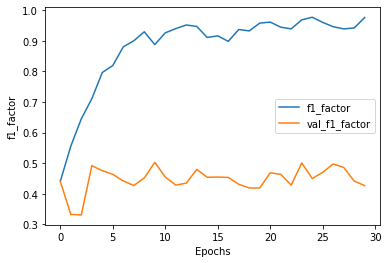

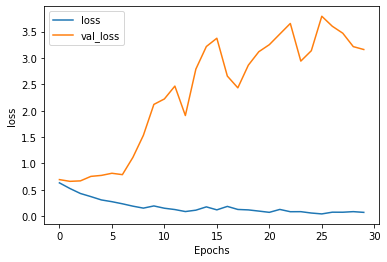

In [17]:
plot_graphs(history_2, "f1_factor")
plot_graphs(history_2, "loss")